
## Ames Housing Data and Kaggle Challenge

Part 4 -  This notebook choose the Top 10 features based on the output from ***"Ames_Subset Selection in Python.ipynb"***, and see how it compare with our original model with all features

------------
Best Subset Selection (result from the Top10 Forward and Top10 Backward Stepwise Selection)
------------
- Total_SF           39.724766
- Neighborhood     1471.621870
- Overall Qual     9999.805385
- Bsmt Unf SF       -19.722646
- Kitchen Qual    11849.345263
- Garage Area        27.314289
- Fireplace Qu     2997.425554
- Overall Cond     4979.112681
- Yr Sold          -281.931927
- Year Built        245.409920




In [1]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#regression models
import sklearn  #to show version
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV, KFold,cross_validate
from sklearn import preprocessing
from sklearn import metrics

#for OLS
import statsmodels.api as sm

%matplotlib inline

In [2]:
#package versions
#show versions of packages
print('pandas: ', pd.__version__)
print('seaborn: ', sns.__version__)
print('numpy: ', np.__version__)
print('sklearn', sklearn.__version__)

pandas:  1.3.4
seaborn:  0.11.1
numpy:  1.21.4
sklearn 0.24.1


In [3]:
import warnings
warnings.filterwarnings('ignore')

### USER DEFINED VARIABLES

In [4]:
#store the resutt of regression models
regression_dict = {}

#we will use the same alphas for different regression models
my_alphas = np.linspace(10, 200, 100)

#parameter for cross validation
crossval = KFold(n_splits=5, shuffle=True, random_state=52)

### USER DEFINED FUNCTIONS

In [5]:
def rmodel_crossval(model_type, alphas, X_train, y_train, X_val, y_val, dic):
    ''' this function is to use cross validation, loop and search the best alpha
    parameter: model_type ('Ridge' or 'Lasso' or 'Enet'), list of alpha,
    X_train, y_train, X_val, y_val, dic(dictionary of the regression result)
    
    return: optimal alpha based on the range of alpha, the rest of the result will be added in the dictionary
    '''
    
    val_score_list = []    #this is out X_val and y_val
    train_score_list = []  #this is our X_train and y_train
    cv_score_list = []     #this is our Cross validation from (X_train)
    mse_train_list = []     #this is our mean squared error for train
    mse_val_list = []     #this is our mean squared error for val
    rmse_train_list = []     #this is our root mean squared error
    rmse_val_list = []     #this is our root mean squared error
    
    #loop for each alpha
    for alpha in alphas:
###BEGIN LOOP        
        #print("Trying for alpha:",alpha )
        
        if model_type == 'Lasso':
            rmodel = Lasso(alpha = alpha)
        elif model_type == 'Ridge':
            rmodel = Ridge(alpha = alpha)
        elif model_type == 'Enet':
            rmodel = ElasticNet(alpha = alpha)
        else:
            print('Invalid Model Type, Lasso, Ridge')
            return None

        cv = cross_validate(
            rmodel, X_train, y_train, scoring='r2', cv=crossval, 
            return_train_score = True)
        
        train_score_list.append(np.mean(cv['train_score']))
        cv_score_list.append(np.mean(cv['test_score']))
            
        #fit  Train
        rmodel.fit(X_train,y_train)
        y_train_pred = rmodel.predict(X_train)
        mse_train_list.append(metrics.mean_squared_error(y_train, y_train_pred))
        rmse_train_list.append(metrics.mean_squared_error(y_train, y_train_pred, squared=False))
        
        #predict Val
        y_pred = rmodel.predict(X_val)
        mse_val_list.append(metrics.mean_squared_error(y_val, y_pred))
        rmse_val_list.append(metrics.mean_squared_error(y_val, y_pred, squared=False))
        
        val_score_list.append(rmodel.score(X_val, y_val))
###END LOOP
    
    
    #after looping, search the optimal alpha
    optimal_alpha_index = np.argmax(val_score_list)
    optimal_alpha = alphas[optimal_alpha_index]
    
    #maximum score in our validation data
    val_score = np.max(val_score_list)
    
    #train score using the same alpha
    train_score = train_score_list[optimal_alpha_index]
    
     #train mse using the same alpha
    mse_train_score = mse_train_list[optimal_alpha_index]
    mse_val_score = mse_val_list[optimal_alpha_index]
    
    #train rmse using the same alpha
    rmse_train_score = rmse_train_list[optimal_alpha_index]
    rmse_val_score = rmse_val_list[optimal_alpha_index]
    
    #lets plot the results
    rmodel_plot(
            cv_score_list, train_score_list, val_score_list,alphas, optimal_alpha,
        model_type)
    
    
    
    print('Alpha:', optimal_alpha)
    print('R2 of Train:', train_score, ', R2 of Val:', val_score)
    print('MSE of Train,', mse_train_score, ', MSE of Val', mse_val_score)
    print('RMSE of Train,', rmse_train_score, ', RMSE of Val', rmse_val_score)

    model_print = model_type + '(cross_validate)'
    
    dic[model_print] = {'alpha': optimal_alpha, 
                                   'train_score': round(train_score,4), 
                                   'validation_score' : round(val_score,4),
                                   'mse_train': round(mse_train_score,4), 
                                   'mse_val':round(mse_val_score,4), 
                                   'rmse_train': round(rmse_train_score,4),
                                   'rmse_val': round(rmse_val_score,4)}
    
    return optimal_alpha

In [6]:
def rmodel_plot(cross_val_score, train_score_list, val_score_list, alphas, optimal_alpha,
    model_type):
    
    '''plotting the optimal alpha and the r2 score of cross validation, train data, and validation data
    parameters: cross_val_score, train_score_list, alphas, optimal_alpha,
                model_type, val_score_list
    return: no return, just plot the graph
    '''
    
    #set figure size
    plt.figure(figsize = (7,5))
    
    #cross validation score
    sns.lineplot(y = cross_val_score, x = alphas, 
                 label = 'CrossVal from X_train')
    
    #training data score
    sns.lineplot(y = train_score_list, x = alphas, 
                 label = 'Training Data (X_train)')
    
    #vertical line for the optimal alpha
    plt.axvline(x=optimal_alpha, linestyle='--')
    
    
    #
    sns.lineplot(y = val_score_list, x = alphas, 
                     label = 'Validation Data (X_val)')
    
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.title(model_type)
    plt.xlabel('alphas')
    plt.ylabel('r2 (score)')
    
    plt.legend()
    plt.show()

In [7]:
def get_r2_mse(model, model_name, alpha, x_train, x_val, y_train, y_val, reg_dict, add_dic=False):
    '''to help in getting r2, mse and rmse in different models
    parameter: model, x_train, x_val, y_train, y_val, 
    reg_dict (dictionary to add the result), 
    add_dic (if we want to add the result in dictionary)'''
    
    #fit the model
    model.fit(x_train, y_train)
    
    #r2
    train_score = model.score(x_train, y_train)
    val_score = model.score(x_val, y_val)

    #predict train and validation
    y_pred_train = model.predict(x_train)
    y_pred_val = model.predict(x_val)

    #mean square error for train
    mse_train = metrics.mean_squared_error(y_pred_train, y_train)
    rmse_train = metrics.mean_squared_error(y_pred_train, y_train, squared=False)

    #mean square error for val
    mse_val = metrics.mean_squared_error(y_pred_val, y_val)
    rmse_val = metrics.mean_squared_error(y_pred_val, y_val, squared=False)
    
    print('Alpha:', alpha)
    print('R2 of Train:', train_score, ', R2 of Val:', val_score)
    print('MSE of Train,', mse_train, ', MSE of Val', mse_val)
    print('RMSE of Train,', rmse_train, ', RMSE of Val', rmse_val)

    if add_dic:
        regression_dict[model_name] = {'alpha': round(alpha,4), 
                                   'train_score': round(train_score,4), 
                                   'validation_score' : round(val_score,4),
                                   'mse_train': round(mse_train,4), 
                                   'mse_val':round(mse_val,4), 
                                   'rmse_train': round(rmse_train,4),
                                   'rmse_val': round(rmse_val,4)}

## Loading of train dataset with additional features

In [8]:
df_train = pd.read_csv("../datasets/train_wfeature_all.csv")
df_train.head()

,Unnamed: 0,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,...,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,HouseAge,Remodel_Age,is_Remodeled,Total_SF
0,0,109,533352170,60,6.0,79.0,13517,2,3,2.0,...,0,0,3,2010,6.0,130500,34,29,0,2204.0
1,1,544,531379050,60,6.0,43.0,11492,2,3,2.0,...,0,0,4,2009,6.0,220000,13,1,1,3035.0
2,2,153,535304180,20,6.0,68.0,7922,2,4,2.0,...,0,0,1,2010,6.0,109000,57,54,0,2114.0
3,3,318,916386060,60,6.0,73.0,9802,2,4,2.0,...,0,0,4,2010,6.0,174000,4,1,1,1828.0
4,4,255,906425045,50,6.0,82.0,14235,2,3,2.0,...,0,0,3,2010,6.0,138500,110,93,0,2121.0


In [9]:
#drop unnecessary columns
df_train.drop(columns=['Unnamed: 0', 'Id', 'PID'], inplace=True)

In [10]:
#check the number of data points and columns
df_train.shape

(1955, 79)

In [11]:
#check that there is no null values
df_train.isnull().sum()[df_train.isnull().sum()>0].sort_values()

Series([], dtype: int64)

In [12]:
df_train.dtypes

MS SubClass       int64
MS Zoning       float64
Lot Frontage    float64
Lot Area          int64
Street            int64
                 ...   
SalePrice         int64
HouseAge          int64
Remodel_Age       int64
is_Remodeled      int64
Total_SF        float64
Length: 79, dtype: object

***define X  and y***

In [13]:

X=df_train[['Total_SF', 'Neighborhood', 'Overall Qual', 'Bsmt Unf SF', 'Kitchen Qual', 'Garage Area', 
            'Fireplace Qu', 'Overall Cond', 'Yr Sold', 'Year Built']]
y=df_train['SalePrice']

In [14]:
#check the p-value using the OLS from statsmodel.api
ols = sm.OLS(y, X).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                          1.411e+04
Date:                Thu, 03 Feb 2022   Prob (F-statistic):                        0.00
Time:                        17:36:40   Log-Likelihood:                         -22234.
No. Observations:                1955   AIC:                                  4.449e+04
Df Residuals:                    1945   BIC:                                  4.454e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Total_SF        39.7248      1.040     38.203      0.000      37.685      41.764
Neighborhood  1471.6219    109.158     13.482      0.000    1257.544    1685.700
Overall Qual  9999.8054    603.939     16.558      0.000    8815.370    1.12e+04
Bsmt Unf SF    -19.7226      1.231    -16.016      0.000     -22.138     -17.308
Kitchen Qual  1.185e+04   1042.116     11.370      0.000    9805.564    1.39e+04
Garage Area     27.3143      2.963      9.217      0.000      21.503      33.126
Fireplace Qu  2997.4256    313.119      9.573      0.000    2383.342    3611.509
Overall Cond  4979.1127    479.604     10.382      0.000    4038.520    5919.705
Yr Sold       -281.9319     24.619    -11.452      0.000    -330.215    -233.649
Year Built     245.4099     25.465      9.637      0.000     195.468     295.352
==============================================================================
Omnibus:                      120.734   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              443.246
Skew:                           0.188   Prob(JB):                     5.63e-97
Kurtosis:                       5.302   Cond. No.                     8.60e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 8.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### split train datasets into train and validation, 80% train and 20% validation data

In [15]:
#split the data as train and validation
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=52)

In [16]:
#scale the X
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.transform(X_val)

### Create polynomial features from train and val datasets

In [17]:
poly = PolynomialFeatures(
    degree = 2, include_bias = False, interaction_only = False)

In [18]:
X_train_poly = poly.fit_transform(X_train)
polynomial_column_names = poly.get_feature_names(input_features = X_train.columns)
X_train_poly = pd.DataFrame(data = X_train_poly, columns = polynomial_column_names )

In [19]:
X_val_poly = poly.fit_transform(X_val)
polynomial_column_names = poly.get_feature_names(input_features = X_val.columns)
X_val_poly = pd.DataFrame(data = X_val_poly, columns = polynomial_column_names )

In [20]:
#check how many features we have after poly
X_train_poly.shape

(1564, 65)

In [21]:
#scale the X - Poly
ssp = StandardScaler()
X_train_scaled_poly = ssp.fit_transform(X_train_poly)
X_val_scaled_poly = ssp.transform(X_val_poly)

## Linear Regression (without Poly)

In [22]:
# Instantiate model.
lr = LinearRegression()
get_r2_mse(lr, 'LR (no poly)', 0, X_train_scaled, X_val_scaled, y_train, y_val, regression_dict, True)

Alpha: 0
R2 of Train: 0.8728641188009616 , R2 of Val: 0.8885424150724679
MSE of Train, 450350681.1698296 , MSE of Val 414709865.2712874
RMSE of Train, 21221.467460329637 , RMSE of Val 20364.42646556213


## Linear Regression (with Poly)

In [23]:
# Instantiate model.
lrPoly = LinearRegression()

#we will not add this to our dictionary as the result is not good
get_r2_mse(lrPoly, 'LR (with poly)', 0, X_train_scaled_poly, X_val_scaled_poly, y_train, y_val, regression_dict, False)


Alpha: 0
R2 of Train: 0.9019046950904102 , R2 of Val: 0.9180438989811234
MSE of Train, 347480876.12209076 , MSE of Val 304941145.40339977
RMSE of Train, 18640.83893289384 , RMSE of Val 17462.56411307915


***It's overfitting, the train dataset has 100% r2, but the validation score is negative 1.89!
MSE of validation is 10B!!! LR is not a good model for polynomials.***

### Searching for optimal alpha -> RIDGE, LASSO and ELASTiCNET

## Ridge

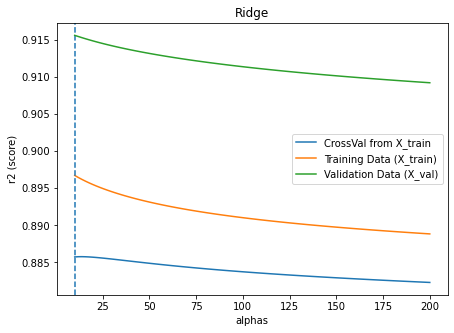

Alpha: 10.0
R2 of Train: 0.896726382392701 , R2 of Val: 0.9156130514130532
MSE of Train, 368326951.89333427 , MSE of Val 313985809.95543456
RMSE of Train, 19191.84597409364 , RMSE of Val 17719.64474687443


In [24]:
#using cross validation to loop  with range of alphas and plot the optimal/chosen alpha

ridgesearch_optimal_alpha = rmodel_crossval('Ridge', my_alphas, X_train_scaled_poly, y_train, 
        X_val_scaled_poly, y_val,regression_dict)



In [25]:
#Using RidgeCV using the same alphas
ridge_cv = RidgeCV(alphas=my_alphas, cv=crossval)
ridge_cv.fit(X_train_scaled_poly, y_train);

#chosen alpha
ridge_cv_alpha = ridge_cv.alpha_

#get our result, but need to create a model again based on the chosen alpha
ridge = Ridge(alpha=ridge_cv_alpha)
get_r2_mse(ridge, 'RidgeCV', ridge_cv_alpha, X_train_scaled_poly, X_val_scaled_poly, y_train, y_val, regression_dict, True)

Alpha: 13.838383838383837
R2 of Train: 0.8955947621308065 , R2 of Val: 0.9153042888614839
MSE of Train, 369832415.11873865 , MSE of Val 315134649.455639
RMSE of Train, 19231.027406738795 , RMSE of Val 17752.032262691475


In [26]:
#Using RandomizedSearchCV, search for the best alpa

param_grid = {'alpha': my_alphas
             }

# Instantiate model.
ridge_model = Ridge()
rand_search_ridge = RandomizedSearchCV(estimator=ridge_model, 
                                 param_distributions=param_grid,
                                 cv = crossval,
                                 n_iter=100)

rand_search_ridge.fit(X_train_scaled_poly, y_train);

#check the optimal alpha based on RandomizedSearchCV
ridgerandomscv_optimal_alpa = rand_search_ridge.best_estimator_.alpha

#get our result, but need to create a model again based on the chosen alpha
ridge = Ridge(alpha=ridgerandomscv_optimal_alpa)
get_r2_mse(ridge, 'Ridge RandomCSV', ridgerandomscv_optimal_alpa, X_train_scaled_poly, X_val_scaled_poly, y_train, y_val, regression_dict, True)




Alpha: 13.838383838383837
R2 of Train: 0.8955947621308065 , R2 of Val: 0.9153042888614839
MSE of Train, 369832415.11873865 , MSE of Val 315134649.455639
RMSE of Train, 19231.027406738795 , RMSE of Val 17752.032262691475


## LASSO

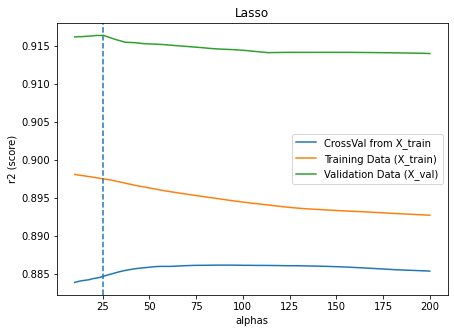

Alpha: 25.353535353535353
R2 of Train: 0.8975094576419466 , R2 of Val: 0.9163477525338821
MSE of Train, 367038586.67699337 , MSE of Val 311252144.02294767
RMSE of Train, 19158.251138269206 , RMSE of Val 17642.339528048644


In [27]:
#using cross validation to loop  with range of alphas and plot the optimal/chosen alpha
lassosearch_optimal_alpha = rmodel_crossval('Lasso', my_alphas, X_train_scaled_poly, y_train, 
        X_val_scaled_poly, y_val,regression_dict)


In [28]:
#Using LassoCV using the same alphas
lasso_cv = LassoCV(alphas=my_alphas,cv = crossval)

#instantiate the model
lasso_cv.fit(X_train_scaled_poly, y_train);

#get the optimal alpha
lasso_cv_alpha = lasso_cv.alpha_

#get our result, but need to create a model again based on the chosen alpha
lasso = Lasso(alpha=ridgerandomscv_optimal_alpa)
get_r2_mse(lasso, 'LassoCV', lasso_cv_alpha, X_train_scaled_poly, X_val_scaled_poly, y_train, y_val, regression_dict, True)


Alpha: 82.92929292929293
R2 of Train: 0.8967609204465286 , R2 of Val: 0.9161780468877303
MSE of Train, 365701557.7487793 , MSE of Val 311883582.4817764
RMSE of Train, 19123.324965831107 , RMSE of Val 17660.226003134172


In [29]:
#do we have any features that zeroed out?
coef = dict(zip(polynomial_column_names, lasso_cv.coef_))

#uncomment if you want to see, but it's quite long
#coef 

## Lasso's coef_
<details>
  <summary>Out of 3159, there are only 30+ Features with coef_, the rest are 0s, expand for details</summary>

        #'MS SubClass Mas Vnr Type': -654.1489403181133,
        #'MS SubClass Mas Vnr Type': -654.1489403181133,
        #'MS SubClass Garage Area': -703.1880977250123,
        #'MS Zoning Condition 1': 732.1944822395341,
        #'MS Zoning Bldg Type': 494.2327493717202,
        #'MS Zoning Functional': 68.22189615343186,
        #'MS Zoning Sale Type': 782.327760433673,
        #'Lot Area Land Contour': 201.0705489834723,
        #'Lot Area Overall Cond': 808.4102640940354,
        #'Lot Area Exterior 1st': 2079.293074914176,
        #'Lot Area Mas Vnr Type': 671.0863274559588,
        #'Lot Area Paved Drive': 1869.3584761342483,
        #'Street Functional': 497.97823447403516,
        #'Lot Shape Kitchen AbvGr': -254.398620531571,
        #'Land Contour Overall Qual': 146.53163425696454,
        #'Utilities Year Remod/Add': 336.4946940202968,
        #'Lot Config Mas Vnr Area': -299.9970301720546,
        #'Land Slope Roof Matl': -241.75796536619774,
        #'Land Slope Kitchen AbvGr': -282.65870164953304,
        #'Neighborhood^2': 1289.2993556183199,
        #'Neighborhood Overall Qual': 2736.0926437310322,
        #'Neighborhood Low Qual Fin SF': -407.32079988508303,
        #'Neighborhood Gr Liv Area': 3116.667530950304,
        #'Neighborhood Fireplace Qu': 1841.1185391045533,
        #'Neighborhood Garage Finish': 369.751068284764,
        #'Condition 1 Overall Qual': 424.15707182282625,
        #'Condition 1 Overall Cond': 633.6837530095626
        #'Condition 1 Functional': 253.53255115924145,
        #'Condition 1 Paved Drive': 223.46153493956672
    
</details>

In [30]:
#Using RandomizedSearchCV, search for the best alpa
param_grid = {'alpha': my_alphas}

model = Lasso()
lasso_rand_search = RandomizedSearchCV(estimator=model, 
                                 param_distributions=param_grid,
                                cv = crossval,
                                 n_iter=100)

lasso_rand_search.fit(X_train_scaled_poly, y_train);

#check the optimal alpha based on RandomizedSearchCV
lassorandomcsv_optimal_alpha = lasso_rand_search.best_estimator_.alpha


#get our result, but need to create a model again based on the chosen alpha
lasso = Lasso(alpha=lassorandomcsv_optimal_alpha)
get_r2_mse(lasso, 'LassoCV', lassorandomcsv_optimal_alpha, X_train_scaled_poly, X_val_scaled_poly, y_train, y_val, regression_dict, True)



Alpha: 90.60606060606061
R2 of Train: 0.8939274506851947 , R2 of Val: 0.9145172325706126
MSE of Train, 375738496.3774034 , MSE of Val 318063117.7923643
RMSE of Train, 19383.975247028236 , RMSE of Val 17834.32414733915


## ElasticNet

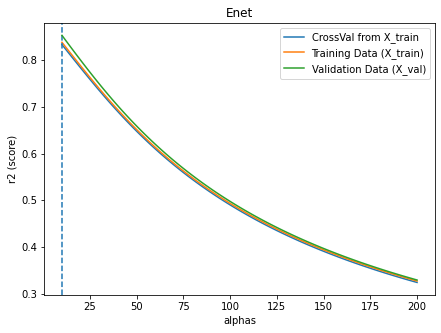

Alpha: 10.0
R2 of Train: 0.838487398920466 , R2 of Val: 0.853404228969503
MSE of Train, 572673126.8940384 , MSE of Val 545451549.9588983
RMSE of Train, 23930.589773217842 , RMSE of Val 23354.904195027182


In [31]:
#using cross validation to loop  with range of alphas and plot the optimal/chosen alpha
enetsearch_optimal_alpha = rmodel_crossval('Enet', my_alphas, X_train_scaled_poly, y_train, 
        X_val_scaled_poly, y_val,regression_dict)


In [32]:
#using ElasticNetCV

# Instantiate model.
enetcv_model = ElasticNetCV(alphas=my_alphas,cv = crossval)

# Fit model 
enetcv_model.fit(X_train_scaled_poly, y_train)

#get the optimal alpha
enetcv_alpha = enetcv_model.alpha_

#get our result, but need to create a model again based on the chosen alpha
enet = ElasticNet(alpha=enetcv_alpha)
get_r2_mse(enet, 'ENetCV', enetcv_alpha, X_train_scaled_poly, X_val_scaled_poly, y_train, y_val, regression_dict, True)


Alpha: 10.0
R2 of Train: 0.838331980674353 , R2 of Val: 0.853404228969503
MSE of Train, 572673126.8940384 , MSE of Val 545451549.9588983
RMSE of Train, 23930.589773217842 , RMSE of Val 23354.904195027182


In [33]:
#Using RandomizedSearchCV, search for the best alpa
param_grid = {'alpha': my_alphas}

model = ElasticNet()
enet_rand_search = RandomizedSearchCV(estimator=model, 
                                 param_distributions=param_grid,
                                 cv = crossval,
                                 n_iter=100)

enet_rand_search.fit(X_train_scaled_poly, y_train);

#check the optimal alpha based on RandomizedSearchCV
enetrandomcsv_optimal_alpha = enet_rand_search.best_estimator_.alpha

#get our result, but need to create a model again based on the chosen alpha
enet = ElasticNet(alpha=enetrandomcsv_optimal_alpha)
get_r2_mse(enet, 'ENet RandomSCV', enetrandomcsv_optimal_alpha, X_train_scaled_poly, X_val_scaled_poly, y_train, y_val, regression_dict, True)


Alpha: 10.0
R2 of Train: 0.838331980674353 , R2 of Val: 0.853404228969503
MSE of Train, 572673126.8940384 , MSE of Val 545451549.9588983
RMSE of Train, 23930.589773217842 , RMSE of Val 23354.904195027182


***Optimal alpha for ElasticNet is 10 for both***

# Summmary of Regression Models

In [34]:
df_reg = pd.DataFrame(regression_dict).T.reset_index()
df_reg.rename(columns={"index":"model_type"}, inplace=True)


In [35]:
#sort by highest R2 of Validation
df_reg.sort_values(by='validation_score', ascending=False)

,model_type,alpha,train_score,validation_score,mse_train,mse_val,rmse_train,rmse_val
4,Lasso(cross_validate),25.353535,0.8975,0.9163,3.670386e+08,3.112521e+08,19158.2511,17642.3395
1,Ridge(cross_validate),10.000000,0.8967,0.9156,3.683270e+08,3.139858e+08,19191.8460,17719.6447
2,RidgeCV,13.838400,0.8956,0.9153,3.698324e+08,3.151346e+08,19231.0274,17752.0323
3,Ridge RandomCSV,13.838400,0.8956,0.9153,3.698324e+08,3.151346e+08,19231.0274,17752.0323
5,LassoCV,90.606100,0.8939,0.9145,3.757385e+08,3.180631e+08,19383.9752,17834.3241
0,LR (no poly),0.000000,0.8729,0.8885,4.503507e+08,4.147099e+08,21221.4675,20364.4265
6,Enet(cross_validate),10.000000,0.8385,0.8534,5.726731e+08,5.454515e+08,23930.5898,23354.9042
7,ENetCV,10.000000,0.8383,0.8534,5.726731e+08,5.454515e+08,23930.5898,23354.9042
8,ENet RandomSCV,10.000000,0.8383,0.8534,5.726731e+08,5.454515e+08,23930.5898,23354.9042


In [84]:
xwin = df_reg.sort_values(by='validation_score', ascending=False).iloc[0:1, 0:1]


'Lasso(cross_validate)'

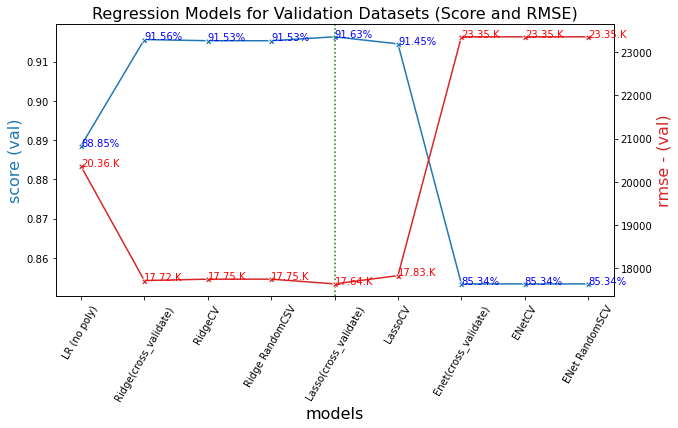

In [85]:
#Create combo chart
fig, ax1 = plt.subplots(figsize=(10,5))
color = 'tab:blue'

#line plot creation
ax1.set_title('Regression Models for Validation Datasets (Score and RMSE)', fontsize=16)

ax1.set_xlabel('models', fontsize=16)
ax1.set_ylabel('score (val)', fontsize=16,color=color)
ax1 = sns.lineplot(x='model_type', y='validation_score', data = df_reg, color=color,marker='X', dashes=False)

ax1.tick_params(axis='x', rotation=60)

# label points for score
for x, y in zip(df_reg['model_type'], df_reg['validation_score']):
    ax1.text(x = x, # x-coordinate position of data label
    y = y, # y-coordinate position of data label
    s = '{:.2f}%'.format(y*100), # data label, formatted to show percentage
    color = 'blue') # set colour of line

    
ax1.axvline(x= xwin.iloc[0]["model_type"], color = 'green', linestyle = 'dotted')

#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

#line plot creation
ax2.set_ylabel('rmse - (val)', fontsize=16,color=color)
ax2 = sns.lineplot(x='model_type', y='rmse_val', data = df_reg, sort=False, color=color,marker='X')

# label points for rmse
for x, y in zip(df_reg['model_type'], df_reg['rmse_val']):
    ax2.text(x = x, # x-coordinate position of data label
    y = y, # y-coordinate position of data label
    s = '{:.2f}.K'.format(y/1000), # data label, formatted to show percentage
    color = 'red') # set colour of line


#show plot
plt.show()

# Summary and Conclusion:

Lasso(cross_validate) with alpha of 25.35 has the highest R2 **91.63%** and lowest RSE of 17.6K. It was a good result considering this only a selection of Top 10 features,  compared to 78 features (with Polynomials is 3159 total features) that has R2 of **92.91%**